# GLOBAL OPR PREDICTION

- Scope: All global banded employees (bands 0-7) (changed to bands 0-5)
- Zones: All zones
- ML perspective:
    - multiclass (main)
    - regression
- ML process: custom multiclass process
- Feature perspective:
    - opr as response
    - previous opr as main feature
    - all bp, competency, target, movement features
    - train=2016-17
    - valid=2018

## INITIALIZATION

In [2]:
%reset -f

import sys, pandas as pd, numpy as np, inspect, re as re, functools as functools, pickle, glob, warnings, os as os

# nlp modules
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')

from tqdm import tqdm
from hyperopt import hp, tpe, STATUS_OK, fmin, Trials
from hyperopt.fmin import fmin
from hyperopt.pyll.stochastic import sample

# sklearn packages
from sklearn.cluster import KMeans
from sklearn.feature_selection import VarianceThreshold
import sklearn.metrics as skm

# some options/variables
randomseed = 1 # the value for the random state used at various points in the pipeline
pd.options.display.max_rows = 50 # specify if you want the full output in cells rather the truncated list
pd.options.display.max_columns = 200

# to display multiple outputs in a cell without usin print/display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# append the scripts path to pythonpath
sys.path.append('./SCRIPTS/')

# ignore warnings (only if you are the kind that would code when the world is burning)
warnings.filterwarnings('ignore')

# plot inline
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# # import the various ml modules
import xgboost as xgb
# from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier, OutputCodeClassifier
# from sklearn.svm import SVC, LinearSVC, NuSVC
# from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
# from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, RidgeClassifierCV, PassiveAggressiveClassifier, SGDClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.neural_network import MLPClassifier

############################################## import the custom modules ################################
import helperfuncs as helper
import feateng as fte
import misc as miscfun
import oprfunctions as oprfun
from misc import ce_encodings, DataFrameImputer, scalers
from oprfunctions import demo_fn, salary_process

# instantiate the classes
helpers = helper.helper_funcs()
cust_funcs = fte.custom_funcs()
feat_sel = miscfun.feat_selection()

#############################################################################################################
# global function to flatten columns after a grouped operation and aggregation
# outside all classes since it is added as an attribute to pandas DataFrames
def __my_flatten_cols(self, how="_".join, reset_index=True):
    how = (lambda iter: list(iter)[-1]) if how == "last" else how
    self.columns = [how(filter(None, map(str, levels))) for levels in self.columns.values] \
    if isinstance(self.columns, pd.MultiIndex) else self.columns
    return self.reset_index(drop=True) if reset_index else self
pd.DataFrame.my_flatten_cols = __my_flatten_cols

Using TensorFlow backend.


In [4]:
%run -i ./SCRIPTS/dicts_cols.py

## SETUP THE ADLS

In [5]:
from azure.datalake.store import core, lib, multithread

tenant = 'cef04b19-7776-4a94-b89b-375c77a8f936'
resource = 'https://datalake.azure.net/'
client_id = 'e9aaf06a-9856-42a8-ab3c-c8b0d3a9b110'
client_secret = 'DlbuV60szYT2U0CQNjzwRA55EsH42oX92AB7vbD2clk='

adlcreds = lib.auth(tenant_id = tenant,
                   client_secret = client_secret,
                   client_id = client_id,
                   resource = resource)

subs_id = '73f88e6b-3a35-4612-b550-555157e7059f'
adls = 'edhadlsanasagbdev'

adlsfsc = core.AzureDLFileSystem(adlcreds, store_name=adls)

In [6]:
## TO READ AND WRITE FILES

# with adlsfsc.open('root/anasandbox/people/opr10x/input/navigate/belts/belts_withdates.xlsx') as f:
#     x = pd.read_excel(f)
# with adlsfsc.open('root/anasandbox/people/opr10x/input/navigate/belts/belts_withdates_copy.csv', 'wb') as f:
#     x.to_csv()

## OPR files initialization

In [836]:
# %run -i ../input/SCRIPTS/opr_script.py

## load backup
opr_files = open('../working/opr_backup.pkl', 'rb')
opr_train = pickle.load(opr_files)
opr_valid = pickle.load(opr_files)
opr_files.close()

## BluePrint

In [837]:
# %run -i ../input/SCRIPTS/blueprint_script.py
# %run -i ../input/SCRIPTS/blueprint_script_new.py

# load backup
# raw files untouched. one-time backup.
# bp_files = open('../working/bp_backup.pkl', 'rb')
# bp_2016 = pickle.load(bp_files)
# bp_2017 = pickle.load(bp_files)
# bp_2018 = pickle.load(bp_files)
# bp_files.close()

# load backup
# processed and appended blueprint master file
bpfull_files = open('../working/bpfull_backup.pkl', 'rb')
bp_full = pickle.load(bpfull_files)
bpfull_files.close()

## MISC

### Features
- MRS features (compare ratio)
- Demographics
- Salary
- TeamSize and TeamSize_Difference

In [838]:
%run -i ../input/SCRIPTS/misc_script.py

(21975, 10)


## Competency

In [839]:
# %run -i ../input/SCRIPTS/competency_script.py

# compfull = open('../working/comp_backup.pkl', 'rb')
# comp_full = pickle.load(compfull)
# compfull.close()

compfull2 = open('../working/comp_backup2.pkl', 'rb')
comp_full = pickle.load(compfull2)
compfull2.close()

## Target

In [840]:
# %run -i ../input/SCRIPTS/target_script.py

tarpickle = open('../working/tar_backup.pkl', 'rb')
tar_reshaped = pickle.load(tarpickle)
tarpickle.close()

## Movement

### Features
- movement features
- time in band
- career velocity features

In [841]:
%run -i ../input/SCRIPTS/movements_script.py
# %run ../working/Career_Velocity_Metric_eg_2018_used.ipynb

(24087, 2)
(22536, 2)
(3260, 2)
(4930, 2)
(5656, 2)
(28963, 2)
(32652, 2)
(36680, 2)


## NAVIGATE DATA and related

### Features
- BELTS
- CAREER ASPIRATIONS
- COMPETENCY APPRAISAL
- GMT-GMBA
- GTP / PeopleBets / ZTP
- EDUCATION (nothing for now)
- ENGAGEMENT (not present for 2016)
- PDP (lot more work here. time since PDP and related)
- TURNOVER/BUSINESS IMPACT
- MOBILITY

In [842]:
os.listdir('../input/Navigate/')

%run -i ../input/SCRIPTS/navigate_script.py

['Belts.xlsx',
 'Career Aspirations.xlsx',
 'Comp appraisal.xlsx',
 'comp_appraisal_comments',
 'Education.xlsx',
 'GMT-GMBA.xlsx',
 'Mobility.xlsx',
 'PDP',
 'Talent Pool members (GTP,ZTP,People Bet).xlsx',
 'Turnover and Business impact.xlsx']

(46633, 3)
(1858, 8)
(220, 9)
(1524, 25)
(14385, 349)
(142450, 2)


## PDI (org chart related)

### Features
- PDI
- Team KPIs (as manager, team attributes)

In [843]:
%run -i ../input/SCRIPTS/pdi_script.py

(2858, 3)
(3214, 3)


## ORG chart features

In [844]:
# mngr_lvl_orgfeats_train = helpers.csv_read('../input/org_chart_feats/manager_level_GR_2017.csv')
# mngr_lvl_orgfeats_train.columns = ['global_id', 'drgr', 'fsgr', 'drplus1gr']
# mngr_lvl_orgfeats_train['year'] = 2017
# mngr_lvl_orgfeats_valid = helpers.csv_read('../input/org_chart_feats/manager_level_GR_2018.csv')
# mngr_lvl_orgfeats_valid.columns = ['global_id', 'drgr', 'fsgr', 'drplus1gr']
# mngr_lvl_orgfeats_valid['year'] = 2018

# team_lvl_orgfeats_train = helpers.csv_read('../input/org_chart_feats/team_level_GR_2017.csv')
# team_lvl_orgfeats_train.columns = ['global_id', 'lmgr', 'slmandlmlevelgr', 'lmanddrlevelgr']
# team_lvl_orgfeats_train['year'] = 2017
# team_lvl_orgfeats_valid = helpers.csv_read('../input/org_chart_feats/team_level_GR_2018.csv')
# team_lvl_orgfeats_valid.columns = ['global_id', 'lmgr', 'slmandlmlevelgr', 'lmanddrlevelgr']
# team_lvl_orgfeats_valid['year'] = 2018

## Normalized competency

In [845]:
# normca_train = helpers.csv_read('../input/COMP/norm_ca_17_0411.csv', cols_to_keep=normca_cols)
# normca_train['year'] = 2017
# normca_valid = helpers.csv_read('../input/COMP/norm_ca_18_0411.csv', cols_to_keep=normca_cols)
# normca_valid['year'] = 2018

## ADS creation

In [855]:
%run -i ../input/SCRIPTS/ads_prepare.py

datetime feature engineering is happening ... 

(31, 2)


In [720]:
## load backup
# ads_backup = open('../working/ads_backup.pkl', 'rb')
# train = pickle.load(ads_backup)
# valid = pickle.load(ads_backup)
# ytrain = pickle.load(ads_backup)
# yvalid = pickle.load(ads_backup)
# ads_backup.close()

In [812]:
# ## save backup
# ads_backup = open('../working/experiment.pkl','wb')
# pickle.dump(train, ads_backup)
# pickle.dump(valid, ads_backup)
# pickle.dump(ytrain, ads_backup)
# pickle.dump(yvalid, ads_backup)
# ads_backup.close()

# ## load backup
# ads_backup = open('../working/experiment.pkl', 'rb')
# train = pickle.load(ads_backup)
# valid = pickle.load(ads_backup)
# ytrain = pickle.load(ads_backup)
# yvalid = pickle.load(ads_backup)
# ads_backup.close()

In [813]:
train.shape, valid.shape
valid['global_id'].nunique()

((36731, 120), (26756, 120))

26756

In [814]:
dummy_train = train.copy()
dummy_valid = valid.copy()
dummy_train['response'] = ytrain
dummy_valid['response'] = yvalid

# filter for bands [7] and bands [6,7]
train_0to6 = dummy_train[dummy_train['employee_band']<13]
valid_0to6 = dummy_valid[dummy_valid['employee_band']<13]
train_0to6.reset_index(drop=True, inplace=True)
valid_0to6.reset_index(drop=True, inplace=True)
ytrain_0to6 = train_0to6.response.values
yvalid_0to6 = valid_0to6.response.values
train_0to6.drop(columns=['response'], inplace=True)
valid_0to6.drop(columns=['response'], inplace=True)

# filter for bands 0-5
train_0to5 = dummy_train[dummy_train['employee_band']<11]
valid_0to5 = dummy_valid[dummy_valid['employee_band']<11]
train_0to5.reset_index(drop=True, inplace=True)
valid_0to5.reset_index(drop=True, inplace=True)
ytrain_0to5 = train_0to5.response.values
yvalid_0to5 = valid_0to5.response.values
train_0to5.drop(columns=['response'], inplace=True)
valid_0to5.drop(columns=['response'], inplace=True)

train.shape, train_0to5.shape, train_0to6.shape
valid.shape, valid_0to5.shape, valid_0to6.shape

np.array(np.unique(ytrain_0to5, return_counts=True)).T

((36731, 120), (8333, 120), (19447, 120))

((26756, 120), (5904, 120), (13900, 120))

array([[0.000e+00, 2.760e+02],
       [1.000e+00, 5.230e+02],
       [2.000e+00, 3.743e+03],
       [3.000e+00, 2.508e+03],
       [4.000e+00, 9.850e+02],
       [5.000e+00, 2.980e+02]])

# THE MAIN BREAK LINE. execute all above if running iterations

In [815]:
train_0to5.shape, ytrain_0to5.shape
valid_0to5.shape, yvalid_0to5.shape

((8333, 120), (8333,))

((5904, 120), (5904,))

In [816]:
# %run -i ../input/SCRIPTS/subset_and_find_topfeatures.py
# xgb.plot_importance(model, max_num_features=20)

In [817]:
train_0to5.shape, ytrain_0to5.shape
valid_0to5.shape, yvalid_0to5.shape

train_0to5['response'] = ytrain_0to5
valid_0to5['response'] = yvalid_0to5
train_0to5.drop_duplicates(subset=['global_id', 'year'], inplace=True)
valid_0to5.drop_duplicates(subset=['global_id', 'year'], inplace=True)
ytrain_0to5 = np.array(train_0to5['response'])
yvalid_0to5 = np.array(valid_0to5['response'])
train_0to5.drop(columns=['response'], inplace=True)
valid_0to5.drop(columns=['response'], inplace=True)

train_0to5.shape, ytrain_0to5.shape
valid_0to5.shape, yvalid_0to5.shape

((8333, 120), (8333,))

((5904, 120), (5904,))

((8333, 120), (8333,))

((5904, 120), (5904,))

In [727]:
train_0to5.to_csv('train0to5.csv', index=False)
valid_0to5.to_csv('valid0to5.csv', index=False)
(pd.DataFrame(ytrain_0to5)).to_csv('ytrain0to5.csv', index=False)
(pd.DataFrame(yvalid_0to5)).to_csv('yvalid0to5.csv', index=False)

## END OF MAIN ADS PREPARATION

In [818]:
experiment_cols = ['global_id', 'year', 'zone', 'employee_band', 'opr_prev', 'opr_prev_prev', 
                   'mr_pers_compgroup_year_comp_score_mean_functional_competencies',
                   'mr_pers_compgroup_year_comp_score_mean_leadership_competencies',
                   'mr_pers_compgroupl1_year_comp_score_mean_leadership_competencies_develop_people',
                   'mr_pers_compgroupl1_year_comp_score_mean_leadership_competencies_dream_big',
                   'mr_pers_compgroupl1_year_comp_score_mean_leadership_competencies_live_our_culture',
                  'time_in_band', 'position_tenure', #tenure features
                  'position_velocity', 'index_average', #career velocity
                  'net_target', 'target_delta', #target
                  'pdi_score', 'pdi_score_category', #pdi
                  'fc_count', 'lc_count', #PDP
                  'function', #function
                   'ebm_level', #EBM
                  'talent_pool', 'count_of_belts', #talent pool and belts flag
                   'talentpool_renomination', #talent pool renimation
                  'teamsize', 'teamsize_delta', #teamsize and teamsize between years
                  'engagement_score', 'manager_effectiveness_score'] #engagement features

In [819]:
train_experiment = train_0to5[experiment_cols]
valid_experiment = valid_0to5[experiment_cols]

In [820]:
# ################ to filter out 2016 #####################

# train_experiment['response'] = ytrain_0to5
# trainnew = train_experiment[train_experiment['year']==2017]
# trainnew.reset_index(drop=True, inplace=True)
# ytrainnew = np.array(trainnew.response)
# trainnew.drop(columns=['response'], inplace=True)
# train_experiment.drop(columns=['response'], inplace=True)

# validnew = valid_experiment.copy()
# yvalidnew = yvalid_0to5.copy()

In [821]:
train_experiment.zone.value_counts()

ZONE NORTH AMERICA      2180
ZONE SOUTH AMERICA      1980
ZONE EUROPE             1231
ZONE ASIA PACIFIC       1035
GLOBAL                   996
ZONE MIDDLE AMERICAS     570
ZXV                      221
ZONE AFRICA              120
Name: zone, dtype: int64

In [823]:
train_experiment.shape, ytrain_0to5.shape
valid_experiment.shape, yvalid_0to5.shape

# trainnew.shape, ytrainnew.shape
# validnew.shape, yvalidnew.shape

((8333, 30), (8333,))

((5904, 30), (5904,))

category encoding is happening ... 

category encoding completed 

[0]	train-mlogloss:1.66653	train-merror:0.309439	test-mlogloss:1.7315	test-merror:0.615046
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 50 rounds.
[10]	train-mlogloss:0.920298	train-merror:0.060474	test-mlogloss:1.44639	test-merror:0.551256
[20]	train-mlogloss:0.576374	train-merror:0.023323	test-mlogloss:1.37037	test-merror:0.546596
[30]	train-mlogloss:0.394484	train-merror:0.008826	test-mlogloss:1.35414	test-merror:0.542483
[40]	train-mlogloss:0.291679	train-merror:0.004697	test-mlogloss:1.36461	test-merror:0.543183
[50]	train-mlogloss:0.227346	train-merror:0.00156	test-mlogloss:1.38325	test-merror:0.54276
[60]	train-mlogloss:0.184718	train-merror:0.000551	test-mlogloss:1.40745	test-merror:0.543176
[70]	train-mlogloss:0.153752	train-merror:0.000136	test-mlogloss:1.43397	test-merror:0.5454
[80]	train-mlogloss:0.132569	train-merror

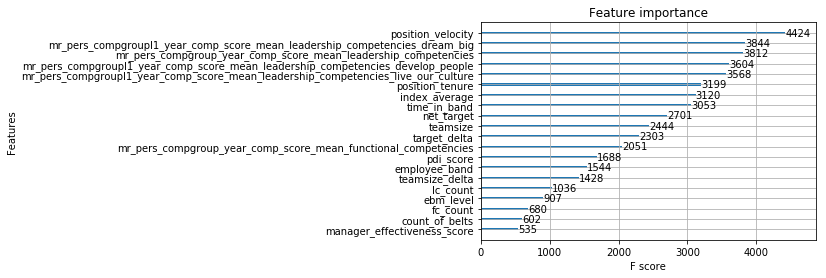

In [759]:
%run -i ../input/SCRIPTS/ml_xgboost.py

xgb_model, xgb_feat_names, xgtrain, xgtest, xgbpred, xgb_pred_probs = quick_model_xgb(train=trainnew.copy(), 
                                                                                      valid=validnew.copy(), 
                                                                                      ytrain=ytrainnew.copy(),
                                                                                      yvalid=yvalidnew.copy())

feature_importance_df1 = get_xgb_imp(xgb_model)
xgb.plot_importance(xgb_model, max_num_features=20)
# feature_importance_df1.to_csv('experiment_featureimp.csv', index=False)

In [ ]:
%run -i ../input/SCRIPTS/rules_and_shape.py

In [776]:
rules_and_shape_df.head(2)

xxx=pd.DataFrame(np.array(np.unique(rules_and_shape_df.pred, return_counts=True)).T)
xxx.columns = ['a', 'b']
xxx['dist'] = 100*(xxx['b']/xxx['b'].sum())
print('the rules and shape predictions distribution')
xxx
print('\n')

#rules_and_shape_df['pred'].value_counts()
#rules_and_shape_df.response.value_counts()
rules_and_shape_df['pred_mapped'] = rules_and_shape_df['pred'].map(dep_dict)
rules_and_shape_df['response_mapped'] = rules_and_shape_df['response'].map(dep_dict)

print('the rules and shape confusion matrix')
skm.confusion_matrix(y_pred=rules_and_shape_df['pred_mapped'], 
                     y_true=rules_and_shape_df['response_mapped'])
print('\n')

print('the rules and shape precision score in the order -> [1A, 3B, 3A, 4B, 4A]')
100*(skm.precision_score(y_pred=rules_and_shape_df['pred_mapped'], 
                         y_true=rules_and_shape_df['response_mapped'], average=None))
print('\n')

preddf = rules_and_shape_df[['zone', 'response_mapped', 'pred_mapped']].copy()
preddf['exact'] = np.where(preddf['response_mapped']==preddf['pred_mapped'], 1, 0)
preddf['dev'] = (preddf['response_mapped'] - preddf['pred_mapped']).astype(int).abs()
preddf['dev1'] = np.where(preddf['dev']<2, 1, 0)

preddf2 = preddf.groupby(['zone']).agg({'response_mapped':np.size, 'exact':np.sum, 'dev1':np.sum}).reset_index()
preddf2['accuracy_exact'] = (preddf2['exact']/preddf2['response_mapped'])*100
preddf2['accuracy_dev1'] = (preddf2['dev1']/preddf2['response_mapped'])*100
print('the zone level statistics')
preddf2
print('\n')

print('total accuracy: ', preddf2.exact.sum()/preddf2.response_mapped.sum())
print('dev 1 accuracy: ', preddf2.dev1.sum()/preddf2.response_mapped.sum())

,zone,response,rules_prediction,s_opr,pred,pred_mapped,response_mapped
0,ZONE EUROPE,1B,nan,1B,1B,0,0
1,ZONE EUROPE,1A,nan,1A,1A,1,1


the rules and shape predictions distribution


,a,b,dist
0,1A,297,5.03049
1,1B,167,2.82859
2,3A,1373,23.2554
3,3B,3034,51.3889
4,4A,295,4.99661
5,4B,738,12.5




the rules and shape confusion matrix


array([[  57,   19,   83,   11,    7,    6],
       [  30,   83,  168,   37,   20,    5],
       [  58,  152, 1897,  388,  108,   38],
       [  15,   40,  717,  683,  237,   84],
       [   7,    2,  129,  196,  313,   79],
       [   0,    1,   40,   58,   53,   83]], dtype=int64)



the rules and shape precision score in the order -> [1A, 3B, 3A, 4B, 4A]


array([34.13173653, 27.94612795, 62.52471984, 49.74508376, 42.41192412,
       28.13559322])



the zone level statistics


,zone,response_mapped,exact,dev1,accuracy_exact,accuracy_dev1
0,GLOBAL,657,355,580,54.033486,88.280061
1,ZONE AFRICA,386,161,326,41.709845,84.455959
2,ZONE ASIA PACIFIC,838,410,717,48.926014,85.560859
3,ZONE EUROPE,701,349,580,49.786020,82.738944
4,ZONE MIDDLE AMERICAS,622,294,512,47.266881,82.315113
5,ZONE NORTH AMERICA,1201,735,1097,61.199001,91.340550
6,ZONE SOUTH AMERICA,1262,716,1149,56.735341,91.045959
7,ZXV,237,96,194,40.506329,81.856540




total accuracy:  0.5277777777777778
dev 1 accuracy:  0.8731368563685636


,zone,response,rules_prediction,s_opr,pred
0,ZONE EUROPE,1B,nan,1B,1B
1,ZONE EUROPE,1A,nan,1A,1A


the rules and shape predictions distribution


,a,b,dist
0,1A,297,5.03049
1,1B,167,2.82859
2,3A,1373,23.2554
3,3B,3034,51.3889
4,4A,295,4.99661
5,4B,738,12.5




the rules and shape confusion matrix


array([[  57,   19,   83,   11,    7,    6],
       [  30,   83,  168,   37,   20,    5],
       [  58,  152, 1897,  388,  108,   38],
       [  15,   40,  717,  683,  237,   84],
       [   7,    2,  129,  196,  313,   79],
       [   0,    1,   40,   58,   53,   83]], dtype=int64)



the rules and shape precision score in the order -> [1A, 3B, 3A, 4B, 4A]


array([34.13173653, 27.94612795, 62.52471984, 49.74508376, 42.41192412,
       28.13559322])



the zone level statistics


,zone,response_mapped,exact,dev1,accuracy_exact,accuracy_dev1
0,GLOBAL,657,355,580,54.033486,88.280061
1,ZONE AFRICA,386,161,326,41.709845,84.455959
2,ZONE ASIA PACIFIC,838,410,717,48.926014,85.560859
3,ZONE EUROPE,701,349,580,49.786020,82.738944
4,ZONE MIDDLE AMERICAS,622,294,512,47.266881,82.315113
5,ZONE NORTH AMERICA,1201,735,1097,61.199001,91.340550
6,ZONE SOUTH AMERICA,1262,716,1149,56.735341,91.045959
7,ZXV,237,96,194,40.506329,81.856540




total accuracy:  0.5277777777777778
dev 1 accuracy:  0.8731368563685636


In [610]:
opr_dict = {5.:'4A', 4.:'4B', 3.:'3A', 2.:'3B', 1.:'1A', 0.:'1B'}
trainnew['opr_prev'] = trainnew['opr_prev'].map(opr_dict)
trainnew['opr_prev_prev'] = trainnew['opr_prev_prev'].map(opr_dict)
validnew['opr_prev'] = validnew['opr_prev'].map(opr_dict)
validnew['opr_prev_prev'] = validnew['opr_prev_prev'].map(opr_dict)

ytrainnew = np.vectorize(opr_dict.get)(ytrainnew)
yvalidnew = np.vectorize(opr_dict.get)(yvalidnew)

psg_bands_dict = {0:'0_b', 
                  1:'i_a', 2:'i_b', 
                  3:'ii_a', 4:'ii_b', 
                  5:'iii_a', 6:'iii_b', 
                  7:'iv_a', 8:'iv_b', 
                  9:'v_a', 10:'v_b', 
                  11:'vi_a', 12:'vi_b',
                  13:'vii_a', 14:'vii_b'}
trainnew['employee_band'] = trainnew['employee_band'].map(psg_bands_dict)
validnew['employee_band'] = validnew['employee_band'].map(psg_bands_dict)

xgbpred = np.vectorize(opr_dict.get)(xgbpred)

validnew['opr_2018'] = yvalidnew
validnew['predictions'] = xgbpred

bp_files = open('../working/bp_backup.pkl', 'rb')
bp_2016 = pickle.load(bp_files)
bp_2017 = pickle.load(bp_files)
bp_2018 = pickle.load(bp_files)
bp_files.close()

bp16=bp_2016[['global_id', 'employee_name', 'position_title', 'year']]
bp17=bp_2017[['global_id', 'employee_name', 'position_title', 'year']]
bp18=bp_2018[['global_id', 'employee_name', 'position_title', 'year']]

dummyfull = pd.concat([bp16, bp17], axis=0)
dummyfull = pd.concat([dummyfull, bp18], axis=0)

validnew = validnew.merge(dummyfull, how='left', on=['global_id', 'year'])

# compfull = open('../working/comp_backup.pkl', 'rb')
# comp_full = pickle.load(compfull)
# compfull.close()
# compdummy = comp_full[comp_full['year']=='2018']
# compdummy = compdummy[compdummy['competency_group']=='leadership_competencies']
# compdummy.to_csv('compdummy.csv', index=False)

validnew.to_csv('saz_2018.csv', index=False)

In [55]:
feature_list = helpers.xlsx_read('../input/FEATURE_LIST.xlsx', sheet_name='list')
feature_list = feature_list[feature_list['ml_inclusion']==1]
feature_list = list(feature_list.features)
feature_list.extend(['global_id', 'year'])

trainnew = train_0to5[feature_list]
validnew = valid_0to5[feature_list]

(220, 6)


In [706]:
%run -i ../input/SCRIPTS/ml_catboost.py

cat_model, cat_pred, cat_probs = quick_model_cat(train=trainnew.copy(),
                                                            valid=validnew.copy(),
                                                            ytrain=ytrainnew.copy(),
                                                            yvalid=yvalidnew.copy())

category encoding is happening ... 

category encoding completed 

0:	learn: 0.5454189	test: 0.5094851	best: 0.5094851 (0)	total: 316ms	remaining: 31.2s
20:	learn: 0.5995684	test: 0.5641938	best: 0.5641938 (18)	total: 11.1s	remaining: 41.8s
40:	learn: 0.6372376	test: 0.5658875	best: 0.5662263 (38)	total: 24s	remaining: 34.5s
60:	learn: 0.6688248	test: 0.5719851	best: 0.5728320 (55)	total: 37.1s	remaining: 23.7s
80:	learn: 0.6913871	test: 0.5692751	best: 0.5730014 (61)	total: 48.8s	remaining: 11.4s
99:	learn: 0.7131646	test: 0.5707995	best: 0.5730014 (61)	total: 1m	remaining: 0us

bestTest = 0.573001355
bestIteration = 61

Shrink model to first 62 iterations.
0.5730013550135501
[[  17    6  122   36    1    1]
 [   2   18  247   69    7    0]
 [   7    8 1961  637   25    3]
 [   0    1  565 1148   52   10]
 [   0    0  100  396  229    1]
 [   0    0   38  102   85   10]]


In [114]:
# preddf = validnew[['zone']].copy()
# preddf = pd.concat([preddf.reset_index(drop=True), 
#                     (pd.DataFrame({'predictions':rules_and_shape_df})).reset_index(drop=True)], axis=1)
# preddf['actuals'] = yvalidnew.astype(int)
# preddf['exact'] = np.where(preddf['actuals']==preddf['predictions'], 1, 0)
# preddf['dev'] = (preddf['actuals'] - preddf['predictions']).astype(int).abs()
# preddf['dev1'] = np.where(preddf['dev']<2, 1, 0)

# preddf2 = preddf.groupby(['zone']).agg({'actuals':np.size, 'exact':np.sum, 'dev1':np.sum}).reset_index()
# preddf2['accuracy_exact'] = (preddf2['exact']/preddf2['actuals'])*100
# preddf2['accuracy_dev1'] = (preddf2['dev1']/preddf2['actuals'])*100
# preddf2

In [74]:
# opr_dict = {'4A':5,'4B':4, '3A':3,'3B':2, '1A':1, '1B':0}
# rules_and_shape_df['pred'] = rules_and_shape_df['pred'].map(opr_dict)
# rules_and_shape_df['response'] = rules_and_shape_df['response'].map(opr_dict)
# rules_and_shape_df.drop(columns=['rules_prediction', 's_opr'], inplace=True)
rules_and_shape_df.head(2)

,zone,response,rules_prediction,s_opr,pred
4871,ZONE ASIA PACIFIC,3A,nan,4A,4A
4774,ZONE ASIA PACIFIC,3A,nan,4A,4A


In [109]:
# rules_and_shape_df['exact'] = np.where(rules_and_shape_df['response']==rules_and_shape_df['pred'], 1, 0)
# rules_and_shape_df['dev'] = (rules_and_shape_df['response'] - rules_and_shape_df['pred']).astype(int).abs()
# rules_and_shape_df['dev1'] = np.where(rules_and_shape_df['dev']<2, 1, 0)

# rules_and_shape_df2 = rules_and_shape_df.groupby(['zone']).agg({'response':np.size, 'exact':np.sum, 'dev1':np.sum}).reset_index()
# rules_and_shape_df2['accuracy_exact'] = (rules_and_shape_df2['exact']/rules_and_shape_df2['response'])*100
# rules_and_shape_df2['accuracy_dev1'] = (rules_and_shape_df2['dev1']/rules_and_shape_df2['response'])*100
# rules_and_shape_df2
# rules_and_shape_df2['exact'].sum()/rules_and_shape_df2['response'].sum()
# rules_and_shape_df2['dev1'].sum()/rules_and_shape_df2['response'].sum()

In [187]:
%run -i ../input/SCRIPTS/logit_qm.py

logmodel, logpred, logpredprobs = quick_model_log(train.copy(), valid.copy(), ytrain.copy(), yvalid.copy())

category encoding is happening ... 

category encoding completed 

0.5272277227722773


In [191]:
%run -i ../input/SCRIPTS/knn_qm.py

knnmodel, knnpred, knnpredprobs = quick_model_knn(train.copy(), valid.copy(), ytrain.copy(), yvalid.copy())

category encoding is happening ... 

category encoding completed 

0.489038189533239


In [209]:
xgb_df = pd.DataFrame(xgbpredprobs)
xgb_df['pred'] = xgbpred
xgb_df = xgb_df.add_prefix('xgb_')

log_df = pd.DataFrame(logpredprobs)
log_df['pred'] = logpred
log_df = log_df.add_prefix('log_')

knn_df = pd.DataFrame(knnpredprobs)
knn_df['pred'] = knnpred
knn_df = knn_df.add_prefix('knn_')

all_df = pd.concat([xgb_df, log_df], axis=1)
all_df = pd.concat([all_df, knn_df], axis=1)

all_df['global_id'] = valid['global_id'].copy()
all_df['actuals'] = yvalid

all_df.shape
all_df.to_csv('xgboost_logit_knn_predictions_and_probabilities.csv', index=False)

(5656, 23)

In [107]:
xgbmod.best

{'alpha': 0.036501474743678465,
 'base_score': 0.40671062360557664,
 'colsample_bylevel': 0.6448552711187292,
 'colsample_bytree': 0.7265453955486527,
 'gamma': 0.0017861473716917044,
 'lambda': 0.03320627316568583,
 'max_bin': 250.0,
 'max_delta_step': 3.0,
 'max_depth': 5.0,
 'min_child_weight': 4.5,
 'subsample': 0.7511770999393288}

In [108]:
xgbmod.xgb_train_and_predict()

0.5632956152758133 

[[  44   14   84   25    7    0]
 [  18   46  188   52   16    0]
 [  31   61 1792  608   79    5]
 [  11   12  503  963  182   12]
 [   3    4   86  258  325    6]
 [   0    0   33   75   97   16]] 



In [317]:
# from nltk import word_tokenize

# train['position_title'].fillna('', inplace=True)
# train = helpers.nlp_process_columns(train, nlp_cols=['position_title'])
# train['token'] = train['position_title'].apply(word_tokenize)